<a href="https://colab.research.google.com/github/Henil21/University-Research/blob/main/ITM_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MRI Classification For chest and brain diseases :
***table content***

```
1. Fetching data ⛅ 
2. Helper function for visualizing  our data 🆘
3. visualizing the training data distribution 🔎
4. pre processing ⚙
5. Lets step into modeling 🕺

```

In [1]:
!nvidia-smi  -L
# making sure GPU is connected ✅

GPU 0: Tesla T4 (UUID: GPU-fa293aab-7b02-514f-8f47-620e06ebed83)


##*Getting the data ⛅*

In [2]:
#fetching the data from cloud
Chest_train='/content/drive/MyDrive/Chest/'
Chest_test='/content/drive/MyDrive/Chest-Test'

## *Helper function for Visualizing*🆘

In [3]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def view_random_image(target_dir,target_class):
 
   # getting class vise dir link
   target=target_dir+target_class

   # taking 1 random image from a list of all images under a class
   random_img=random.sample(os.listdir(target),1)

   #as we have stored it in list we need to access it through index which is zero
   image=mpimg.imread(target+'/'+random_img[0])

   fig = plt.figure(figsize=(5, 2))  # Set the width and height of the figure

   
   #plotting image
   plt.imshow(image)
   
   plt.axis("off")
   print(f"img shape:{image.shape}")

img shape:(200, 300)


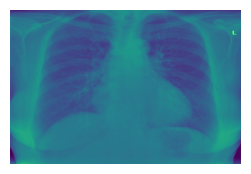

In [4]:
view_random_image(target_dir=Chest_train,target_class='COVID-19')

## Lets visualize the distribution of the training data 🔍

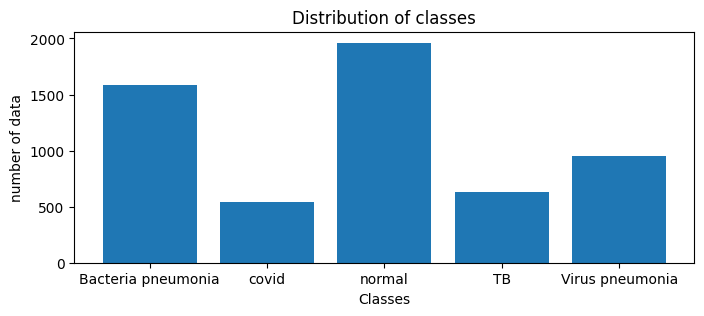

In [5]:

# getting length of the sub classes
BAC_n=len(os.listdir('/content/drive/MyDrive/Chest/Bacteria pneumonia'))
COVID=len(os.listdir('/content/drive/MyDrive/Chest/COVID-19'))
Normal=len(os.listdir('/content/drive/MyDrive/Chest/NORMAL'))
TB=len(os.listdir('/content/drive/MyDrive/Chest/Tuberculosis'))
virus_n=len(os.listdir('/content/drive/MyDrive/Chest/Virus pneumonia'))

classes=['Bacteria pneumonia', "covid",'normal','TB','Virus pneumonia']
values=[BAC_n,COVID,Normal,TB,virus_n]

fig = plt.figure(figsize=(8, 3))  # Set the width and height of the figure

plt.bar(classes,values)
 
# Adding title to the plot
plt.title("Distribution of classes")
 
# Adding label on the y-axis
plt.ylabel('number of data')
 
# Adding label on the x-axis
plt.xlabel('Classes')

plt.show()

## Pre-processing ⚙

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# recaling pixels 
train_data_gen = ImageDataGenerator(rescale=1./255)

# dividing into batches and  
train_generator = train_data_gen.flow_from_directory(
    Chest_train,
    target_size=(200, 300), #targeted shape
    batch_size=32, #32  images per batch
    class_mode='categorical' # we are working with multiclass problem
)


# recaling pixels 
test_data_gen = ImageDataGenerator(rescale=1./255)

# dividing into batches and  
test_generator = train_data_gen.flow_from_directory(
    Chest_test,
    target_size=(200, 300), #targeted shape
    batch_size=32, #32  images per batch
    class_mode='categorical' # we are working with multiclass problem
)

Found 5669 images belonging to 6 classes.
Found 1395 images belonging to 6 classes.


> we got 5669 images divided into 6 sub-classes

run below cell if u wanna see numeric representation

In [7]:
# train_generator[0]

## **Lets step into modeling 🕺**

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPool2D, Activation
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras import Sequential


tf.random.set_seed(42) #why 42? because it is Answer to the Ultimate Question of Life, the Universe, and Everything if you know you know 

Model_1=Sequential([
    Conv2D(32,3,activation='relu', input_shape=(200,300,3)),  #3 is kernal size 
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(6, activation='softmax') # softmax as we are working with multiclass problem
])


In [9]:
Model_1.compile(loss='categorical_crossentropy', # as we got multiple classes
                            optimizer=Adam(), # for now lets dont specify the learning rate,  default is 0.001 and we will also try Rmspromp 
                            metrics=['accuracy'])# evaluation 


In [10]:
history=Model_1.fit(train_generator,
                   epochs=5,
                    steps_per_epoch=len(train_generator ),
                   validation_data=(test_generator),
                   validation_steps=len(test_generator ))

Epoch 1/5
178/178 [==============================] - 1341s 7s/step - loss: 1.0770 - accuracy: 0.5631 - val_loss: 0.7390 - val_accuracy: 0.6796
Epoch 2/5
178/178 [==============================] - 24s 136ms/step - loss: 0.7230 - accuracy: 0.7075 - val_loss: 0.6570 - val_accuracy: 0.7448
Epoch 3/5
178/178 [==============================] - 24s 136ms/step - loss: 0.6193 - accuracy: 0.7516 - val_loss: 0.5647 - val_accuracy: 0.7656
Epoch 4/5
178/178 [==============================] - 24s 134ms/step - loss: 0.5486 - accuracy: 0.7788 - val_loss: 0.5309 - val_accuracy: 0.7670
Epoch 5/5
178/178 [==============================] - 24s 137ms/step - loss: 0.5046 - accuracy: 0.7986 - val_loss: 0.4739 - val_accuracy: 0.7964
